# Introduction

Ce notebook implémente un modèle de Denoising Diffusion Probabilistic Model (DDPM) pour générer des images du dataset MNIST. Il s'agit d'un modèle de diffusion probabiliste qui ajoute progressivement du bruit à des images (processus forward) et apprend à inverser ce processus pour générer de nouvelles images à partir de bruit pur (processus reverse).


## Imports

### Objectif
Cette cellule importe les bibliothèques nécessaires pour construire, entraîner, et évaluer un modèle de Denoising Diffusion Probabilistic Model (DDPM) sur le dataset MNIST.

### Explication
- **torch** : Fournit les tenseurs et les outils pour les réseaux de neurones.
- **torch.nn** et **torch.nn.functional** : Définition des couches (convolutions, batch norm, etc.) et fonctions d'activation (ReLU, etc.).
- **torchvision** et **transforms** : Chargement et prétraitement du dataset MNIST.
- **DataLoader** : Création de batches pour l'entraînement et l'évaluation.
- **matplotlib.pyplot** et **numpy** : Visualisation des résultats et calculs numériques.
- **tqdm** : Barre de progression pour les boucles.
- **math** : Fonctions mathématiques (cos, log, etc.).
- **skimage.metrics.ssim** : Calcul de la métrique SSIM pour évaluer la qualité des images générées.
- **os** : Gestion des fichiers (sauvegarde/chargement du modèle).

### Contexte
Ces imports préparent l'environnement pour toutes les étapes du DDPM : modélisation, données, entraînement, génération, et évaluation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math
from skimage.metrics import structural_similarity as ssim
import os

## Configuration du Device

### Objectif
Détecter si un GPU est disponible pour accélérer les calculs, sinon utiliser le CPU.

### Explication
- La ligne `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")` vérifie la disponibilité de CUDA (GPU). Si disponible, `device="cuda"`, sinon `device="cpu"`.

### Contexte
Le DDPM implique des calculs intensifs (convolutions, matrices). Utiliser un GPU (CUDA) accélère significativement l'entraînement et la génération.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Fonction `betas_for_alpha_bar`

### Objectif
Calculer les paramètres $\beta_t$ (variance du bruit) pour un schedule de diffusion cosinus, qui contrôle l'ajout progressif de bruit.

### Explication
- La fonction prend :
  - `num_diffusion_timesteps` : Nombre de pas $T$.
  - `alpha_bar` : Fonction définissant $\bar{\alpha}_t$, le produit cumulatif des  ${\alpha}_t$.
  - `max_beta` : Valeur maximale de ${\beta}_t$ (par défaut 0.999).
- Boucle sur $(i)$ de $0$ à $(T-1)$ :
  - Calcule $(t_1 = i/T)$ et $(t_2 = (i+1)/T)$.
  - $(\beta_i = \min(1 - \frac{\bar{\alpha}(t_2)}{\bar{\alpha}(t_1)}, \beta_{\max}))$.
- Retourne un tenseur de $(\beta_t)$.

### Formules mathématiques
Dans le DDPM, le schedule cosinus est défini par :
$[
\bar{\alpha}_t = \cos^2\left( \frac{t + s}{T + s} \cdot \frac{\pi}{2} \right), \quad s = 0.008
]$
$[
\beta_t = \min\left(1 - \frac{\bar{\alpha}_{t+1}}{\bar{\alpha}_t}, \beta_{\max}\right)
]$
Le paramètre $(s)$ évite des $(\beta_t)$ trop petits au début.

### Contexte
Les $(\beta_t)$ définissent la quantité de bruit ajouté à chaque timestep dans le processus forward. Le schedule cosinus est préféré au linéaire pour une transition plus douce.

In [ ]:
# ---------------- Diffusion Schedule ----------------

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas, dtype=torch.float32)


## Configuration du Schedule de Diffusion

### Objectif
Définir les paramètres du processus de diffusion (($T=1000$), schedule cosinus) et précalculer les tenseurs pour optimiser le sampling.

### Explication
- Définit $(T=1000)$ (nombre de timesteps).
- Si `schedule_name="linear"`, utilise $(\beta_t)$ linéaires de 0.0001 à 0.02.
- Sinon (`cosine`), utilise `betas_for_alpha_bar` avec :
  $[
  \bar{\alpha}_t = \cos^2\left( \frac{t + 0.008}{1.008} \cdot \frac{\pi}{2} \right)
  ]$
- Calcule :
  - $(\alpha_t = 1 - \beta_t)$
  - $(\bar{\alpha}_t = \prod_{i=1}^t \alpha_i)$
  - $(\bar{\alpha}_{t-1})$ (décalé avec padding).
  - $\sqrt{\bar{\alpha}_t}$ , $\sqrt{1 - \bar{\alpha}_t}$ ,$\sqrt{\frac{1}{\alpha_t}}$

  - Variance postérieure : $(\tilde{\beta}_t = \beta_t \cdot \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t})$.

### Formules mathématiques
- Processus forward :
  $[
  x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
  ]$
- Variance postérieure :
  $[
  \tilde{\beta}_t = \beta_t \cdot \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t}
  ]$

### Contexte
Ces tenseurs précalculés accélèrent les calculs dans les processus forward et reverse en évitant des recalculs à chaque itération.

In [ ]:
T = 1000
schedule_name = "cosine"
if schedule_name == "linear":
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, T).to(device)
elif schedule_name == "cosine":
    betas = betas_for_alpha_bar(
        T,
        lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
    ).to(device)

alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

## Fonction `extract`

### Objectif
Extraire des valeurs d'un tenseur précalculé (comme $(\bar{\alpha}_t)$) pour un batch de timesteps $(t)$.

### Explanation
- Prend :
  - `a` : Tenseur précalculé (e.g., $(\bar{\alpha}_t)$).
  - `t` : Indices des timesteps.
  - `x_shape` : Forme de l'entrée pour broadcasting.
- Extrait `a[t]` et reshape pour correspondre à la forme de l'entrée (batch_size, 1, 1, ...).

### Formules mathématiques
Aucune formule complexe ; utilisé pour broadcaster des scalaires comme $(\sqrt{\bar{\alpha}_t})$ sur des tenseurs d'images.

### Contexte
Simplifie le sampling forward/reverse en appliquant les coefficients à un batch d'images.

In [ ]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    a = a.to(t.device)
    out = a[t]
    return out.view(batch_size, *((1,) * (len(x_shape) - 1)))

## Fonction `q_sample` (Forward Diffusion)

### Objectif
Ajouter du bruit à une image $(x_0)$ au timestep $(t)$ selon le processus forward du DDPM.

### Explication
- Si `noise=None`, génère $(\epsilon \sim \mathcal{N}(0, I))$.
- Calcule :
  $[
  x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon
  ]$
- Utilise `extract` pour obtenir $(\sqrt{\bar{\alpha}_t})$ et $(\sqrt{1 - \bar{\alpha}_t})$.

### Formules mathématiques
$[
q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)
]$
C'est une reparamétrisation pour sampler $(x_t)$ directement sans itérer tous les timesteps.

### Contexte
Simule le processus forward pour l'entraînement, où le modèle apprend à prédire $(\epsilon)$ à partir de $(x_t)$.

In [ ]:
# ---------------- Forward Diffusion ----------------
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

## Fonction `sinusoidal_time_embedding`

### Objectif
Créer des embeddings positionnels pour les timesteps $(t)$, inspirés des transformers.

### Explication
- Divise `dim` en deux pour sin et cos.
- Fréquences : $(\exp(-\log(10000) \cdot \text{arange}(0, \text{half}) / \text{half}))$.
- Calcule $\sin(t \cdot \text{freqs})$ et $\cos(t \cdot \text{freqs})$, concatène.
- Pad si `dim` impair.

### Formules mathématiques
$$
\begin{cases}
PE(t, 2i) = \sin\left( \frac{t}{10000^{2i/d}} \right), \\
PE(t, 2i+1) = \cos\left( \frac{t}{10000^{2i/d}} \right)
\end{cases}
$$


### Contexte
Permet au UNet de conditionner ses prédictions sur le timestep \(t\), essentiel pour le débruitage.

In [ ]:
# ---------------- Sinusoidal Time Embedding ----------------
def sinusoidal_time_embedding(timesteps, dim):
    half = dim // 2
    device = timesteps.device
    t = timesteps.float().unsqueeze(1)
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=device).float() / half)
    args = t * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb

## Classe `ResidualBlock`

### Objectif
Définir un bloc résiduel avec conditionnement temporel pour le UNet.

### Explication
- Structure :
  - Conv2d (3x3) + BatchNorm + ReLU.
  - Ajout de l'embedding temporel via une projection linéaire.
  - Conv2d (3x3) + BatchNorm + ReLU.
  - Connexion résiduelle (conv 1x1 si les canaux changent, sinon identité).

### Formules mathématiques
$[
h = \text{ReLU}(\text{BN}(\text{Conv}(x))) + \phi(t), \quad h = \text{ReLU}(\text{BN}(\text{Conv}(h))) + \text{res_conv}(x)
]$
où $(\phi(t))$ est l'embedding temporel projeté.

### Contexte
Inspiré des ResNets, ce bloc facilite l'entraînement profond et intègre le conditionnement sur $(t)$.

In [ ]:
# ---------------- UNet Components ----------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_embed_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.time_proj = nn.Linear(time_embed_dim, out_channels)
        self.res_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb):
        h = F.relu(self.bn1(self.conv1(x)))
        h = h + self.time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = F.relu(self.bn2(self.conv2(h)))
        return h + self.res_conv(x)

## Classe `SelfAttention`

### Objectif
Ajouter un mécanisme de self-attention au bottleneck du UNet pour capturer des dépendances globales.

### Explication
- Projection QKV via Conv2d 1x1
- Reshape pour attention : [B, C, H, W] → [B, H*W, C].
- Attention multi-head : $Q @ K^T, softmax, @ V$
- Projection finale + résidu.

### Formules mathématiques
$[
\text{Attention}(Q, K, V) = softmax\left( \frac{Q K^T}{\sqrt{d_k}} \right) V, \quad d_k = \text{head_dim}
]$

### Contexte
Améliore la qualité des images générées en captant des relations spatiales globales.

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, channels, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        assert self.head_dim * num_heads == channels, f"Channels ({channels}) must be divisible by num_heads ({num_heads})"
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        B, C, H, W = x.shape
        # QKV projection
        qkv = self.qkv(x).reshape(B, 3 * C, H * W).permute(0, 2, 1)  # [B, H*W, 3*C]
        qkv = qkv.view(B, H * W, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)  # [3, B, num_heads, H*W, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]  # [B, num_heads, H*W, head_dim]
        # Attention
        attn = (q @ k.transpose(-2, -1)) * self.scale  # [B, num_heads, H*W, H*W]
        attn = attn.softmax(dim=-1)
        out = (attn @ v).transpose(2, 3).reshape(B, H * W, C).view(B, C, H, W)  # [B, C, H, W]
        return self.proj(out) + x

## Classe `UNet`

### Objectif
Définir le modèle principal : un UNet conditionné sur $(t)$ pour prédire le bruit $(\epsilon)$.

### Explication
- **Time MLP** : Projette l'embedding temporel via Linear + SiLU + Linear.
- **Encoder** : ResidualBlock (1→128), MaxPool, ResidualBlock (128→256), MaxPool, ResidualBlock (256→512).
- **Bottleneck** : ResidualBlock + SelfAttention.
- **Decoder** : Up-conv + concaténation des skip connections + ResidualBlock.
- **Output** : Conv2d pour prédire le bruit (même forme que l'entrée).

### Formules mathématiques
Le UNet approxime :
$[
\epsilon_\theta(x_t, t)
]$
Loss d'entraînement :
$[
\mathbb{E}_{x_0, t, \epsilon} \left[ \| \epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, t) \|^2 \right]
]$

### Contexte
Cœur du DDPM ; prédit le bruit pour débruiter itérativement les images.

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, model_channels=128, time_embed_dim=256):
        super().__init__()
        self.model_channels = model_channels
        self.time_embed_dim = time_embed_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_embed_dim, time_embed_dim * 4),
            nn.SiLU(),
            nn.Linear(time_embed_dim * 4, time_embed_dim)
        )
        # Encoder
        self.down1 = ResidualBlock(in_channels, model_channels, time_embed_dim)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ResidualBlock(model_channels, model_channels * 2, time_embed_dim)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = ResidualBlock(model_channels * 2, model_channels * 4, time_embed_dim)
        # Bottleneck
        self.bottleneck = ResidualBlock(model_channels * 4, model_channels * 4, time_embed_dim)
        self.attn = SelfAttention(model_channels * 4, num_heads=8)
        # Decoder
        self.up3 = nn.ConvTranspose2d(model_channels * 4, model_channels * 2, 4, stride=2, padding=1)
        self.upconv3 = ResidualBlock(model_channels * 4, model_channels * 2, time_embed_dim)
        self.up4 = nn.ConvTranspose2d(model_channels * 2, model_channels, 4, stride=2, padding=1)
        self.upconv4 = ResidualBlock(model_channels * 2, model_channels, time_embed_dim)
        self.out = nn.Conv2d(model_channels, in_channels, 3, padding=1)

    def forward(self, x, t):
        t_emb = sinusoidal_time_embedding(t, self.time_embed_dim)
        t_emb = self.time_mlp(t_emb)
        x1 = self.down1(x, t_emb)
        x2 = self.down2(self.pool1(x1), t_emb)
        x3 = self.down3(self.pool2(x2), t_emb)
        x_b = self.bottleneck(x3, t_emb)
        x_b = self.attn(x_b)
        up3 = self.up3(x_b)
        cat3 = torch.cat([up3, x2], dim=1)
        x = self.upconv3(cat3, t_emb)
        up4 = self.up4(x)
        cat4 = torch.cat([up4, x1], dim=1)
        x = self.upconv4(cat4, t_emb)
        return self.out(x)

## Fonction `train_model`

### Objectif
Entraîner le UNet sur le dataset MNIST.

### Explication
- Optimiseur : AdamW avec learning rate $(10^{-4})$ et weight decay.
- Scheduler : CosineAnnealingLR pour ajuster le learning rate.
- Boucle sur epochs :
  - Pour chaque batch :
    - Sample $(t)$ aléatoire.
    - Ajoute du bruit via `q_sample`.
    - Prédit le bruit avec le UNet.
    - Calcule MSE loss entre bruit prédit et réel.
    - Backprop + update.
- Trace la courbe de loss et sauvegarde.

### Formules mathématiques
$[
L = \mathbb{E}_{x_0, t, \epsilon} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
]$

### Contexte
Entraîne le modèle à prédire le bruit ajouté pour inverser le processus forward.

In [ ]:
# ---------------- Training ----------------
def train_model(model, dataloader, epochs=50, lr=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    losses = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch = batch.to(device)
            t = torch.randint(0, T, (batch.shape[0],), device=device)
            noise = torch.randn_like(batch)
            x_noisy = q_sample(batch, t, noise)
            predicted_noise = model(x_noisy, t)
            loss = F.mse_loss(predicted_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    plt.figure(figsize=(8, 4))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.savefig('training_loss.png')
    plt.show()
    return losses

## Fonction `p_sample` (Reverse Diffusion)

### Objectif
Effectuer un pas de débruitage dans le processus reverse.

### Explication
- Calcule la moyenne du posterior avec $(\epsilon_\theta(x_t, t))$.
- Ajoute du bruit si $(t > 0)$ en utilisant la variance postérieure.

### Formules mathématiques
$[
\mu_t = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)
]$
$[
x_{t-1} = \mu_t + \sqrt{\tilde{\beta}_t} z, \quad z \sim \mathcal{N}(0, I)
]$

### Contexte
Inverse le processus forward pour générer \(x_{t-1}\) à partir de \(x_t\).

In [ ]:
# ---------------- Reverse Diffusion ----------------
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    model_mean = sqrt_recip_alphas_t * (
        x - (betas_t / sqrt_one_minus_alphas_cumprod_t) * model(x, t)
    )
    if t_index == 0:
        return model_mean
    posterior_variance_t = extract(posterior_variance, t, x.shape)
    noise = torch.randn_like(x)
    return model_mean + torch.sqrt(posterior_variance_t) * noise

## Fonction `generate_with_steps`

### Objectif
Générer des images en itérant `p_sample`, avec option de sauvegarder les étapes intermédiaires.

### Explication
- Part de $(x_T \sim \mathcal{N}(0, I))$.
- Itère de $(t=T-1)$ à $(0)$ en appelant `p_sample`.
- Sauvegarde les images à intervalles réguliers si `show_steps=True`.

### Formules mathématiques
Approximation de $(q(x_{t-1}|x_t, x_0) \approx p_\theta(x_{t-1}|x_t))$.

### Contexte
Génère des images complètes à partir de bruit pur, avec visualisation des étapes de débruitage.

In [ ]:
# ---------------- Generation with Visualization Steps ----------------
@torch.no_grad()
def generate_with_steps(model, n=8, show_steps=True, step_interval=100):
    model.eval()
    x = torch.randn((n, 1, 28, 28), device=device)
    steps_images = [x.cpu()]
    for i in reversed(range(T)):
        t = torch.full((n,), i, device=device, dtype=torch.long)
        x = p_sample(model, x, t, i)
        if show_steps and (i % step_interval == 0 or i == 0):
            steps_images.append(x.clamp(-1, 1).cpu())
    return x.clamp(-1, 1), steps_images

## Chargement du Dataset

### Objectif
Charger et prétraiter le dataset MNIST pour l'entraînement et l'évaluation.

### Explication
- **Transform** : Convertit en tenseur et normalise dans $([-1, 1])$ avec $mean=0.5$, $std=0.5$.
- **DataLoaders** : Crée des itérateurs pour train (batch_size=128, shuffle=True) et test (shuffle=False).

### Formules mathématiques
Normalisation : $((x - 0.5)/0.5 \rightarrow [-1, 1])$, pour aligner avec le bruit $(\mathcal{N}(0, I))$.

### Contexte
Prépare les données pour l'entraînement et l'évaluation du modèle.

In [ ]:
# ---------------- Dataset ----------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)


## Fonction `evaluate_model`

### Objectif
Évaluer la qualité des images générées via des métriques (L2, PSNR, SSIM) et visualisations.

### Explication
- Génère $(n)$ images et compare à $(n)$ images originales aléatoires.
- Calcule :
  - L2 : MSE entre images.
  - PSNR : $(10 \log_{10}(1/\text{MSE}))$.
  - SSIM : Similarité structurelle.
- Visualise : Images côte à côte, histogramme des scores SSIM.

### Formules mathématiques
$[
\text{PSNR} = 10 \log_{10}\left( \frac{1}{\text{MSE}} \right), \quad \text{MSE} = \frac{1}{N} \sum (x - \hat{x})^2
]$
SSIM : Mesure basée sur luminance, contraste, et structure (data_range=1).

### Contexte
Quantifie la fidélité des images générées et visualise les résultats.

In [ ]:
# ---------------- Evaluation ----------------
def evaluate_model(model, dataset, n=64):
    model.eval()
    l2_vals, psnr_vals, ssim_vals = [], [], []
    all_originals, all_generated = [], []

    for _ in range(n // 8):
        # Génération d'images
        generated, _ = generate_with_steps(model, n=8, show_steps=False)
        batch_indices = np.random.choice(len(dataset), 8, replace=False)
        originals = torch.stack([dataset[i][0] for i in batch_indices]).to(device)

        # Dénormalisation [0,1]
        originals_denorm = (originals + 1) / 2
        generated_denorm = (generated + 1) / 2
        all_originals.append(originals_denorm.cpu())
        all_generated.append(generated_denorm.cpu())

        # Calcul des métriques
        for i in range(8):
            orig = originals_denorm[i, 0].cpu().numpy()
            gen = generated_denorm[i, 0].cpu().numpy()
            l2_vals.append(np.mean((orig - gen) ** 2))
            psnr_vals.append(10 * np.log10(1.0 / np.mean((orig - gen) ** 2)))
            ssim_vals.append(ssim(orig, gen, data_range=1.0))

    # Affichage des métriques moyennes
    print(f"Average L2: {np.mean(l2_vals):.4f}")
    print(f"Average PSNR: {np.mean(psnr_vals):.2f} dB")
    print(f"Average SSIM: {np.mean(ssim_vals):.4f}")

    # Concatenation de toutes les images
    all_originals = torch.cat(all_originals)
    all_generated = torch.cat(all_generated)

    # Affichage des images côte à côte
    fig, axes = plt.subplots(8, 16, figsize=(32, 16))
    for i in range(min(32, n)):
        row = i // 8
        col = (i % 8) * 2
        # Original
        axes[row, col].imshow(all_originals[i, 0], cmap='gray')
        axes[row, col].set_title('Original')
        axes[row, col].axis('off')
        # Generated
        axes[row, col + 1].imshow(all_generated[i, 0], cmap='gray')
        axes[row, col + 1].set_title('Generated')
        axes[row, col + 1].axis('off')

    plt.tight_layout()
    plt.savefig('original_vs_generated.png')
    plt.show()

    # Histogramme des SSIM
    plt.figure(figsize=(8, 4))
    plt.hist(ssim_vals, bins=20, color='blue', alpha=0.7)
    plt.xlabel('SSIM Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of SSIM Scores')
    plt.grid(True)
    plt.savefig('ssim_histogram.png')
    plt.show()


## Fonction `visualize_steps`

### Objectif
Visualiser les étapes intermédiaires du processus de débruitage.

### Explication
- Affiche une grille d'images pour chaque étape sauvegardée.
- Étiquettes avec le timestep $(t)$.

### Formules mathématiques
Aucune ; visualisation du processus reverse.

### Contexte
Montre comment le bruit initial devient progressivement une image cohérente.

In [ ]:
# ---------------- Visualization of Denoising Steps ----------------
def visualize_steps(steps_images):
    n_steps = len(steps_images)
    n_samples = steps_images[0].shape[0]
    fig, axes = plt.subplots(n_steps, n_samples, figsize=(n_samples * 1.5, n_steps * 1.5))
    step_times = [T - i * (T // (n_steps - 1)) for i in range(n_steps - 1)] + [0]
    for i, (step_img, step_t) in enumerate(zip(steps_images, step_times)):
        for j in range(n_samples):
            axes[i, j].imshow((step_img[j, 0] + 1) / 2, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, 0].set_ylabel(f"t={step_t}", fontsize=10)
    plt.tight_layout()
    plt.savefig('denoising_steps.png')
    plt.show()

## Bloc Principal (Main)

### Objectif
Exécuter l'ensemble du pipeline : entraîner/charger le modèle, générer des images, visualiser, et évaluer.

### Explication
- Crée le UNet (in_channels=1, model_channels=128, time_embed_dim=256).
- Si le modèle n'est pas sauvegardé :
  - Entraîne pour 50 epochs.
  - Sauvegarde à `improved_ddpm_mnist.pth`.
- Sinon, charge le modèle pré-entraîné.
- Génère 8 images avec visualisation des étapes.
- Évalue sur 64 images (métriques + visualisations).

### Formules mathématiques
Synthèse des formules du DDPM (voir sections précédentes).

### Contexte
Point d'entrée du notebook. Produit des outputs comme :
- `training_loss.png` : Courbe de loss.
- `denoising_steps.png` : Étapes de débruitage.
- `original_vs_generated.png` : Comparaison images originales/générées.
- `ssim_histogram.png` : Distribution des scores SSIM.

Training model...


Epoch 1/50: 100%|██████████| 469/469 [02:06<00:00,  3.72it/s]


Epoch 1/50, Loss: 0.1032


Epoch 2/50: 100%|██████████| 469/469 [02:10<00:00,  3.60it/s]


Epoch 2/50, Loss: 0.0635


Epoch 3/50: 100%|██████████| 469/469 [02:10<00:00,  3.58it/s]


Epoch 3/50, Loss: 0.0558


Epoch 4/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 4/50, Loss: 0.0515


Epoch 5/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 5/50, Loss: 0.0489


Epoch 6/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 6/50, Loss: 0.0469


Epoch 7/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 7/50, Loss: 0.0456


Epoch 8/50: 100%|██████████| 469/469 [02:10<00:00,  3.58it/s]


Epoch 8/50, Loss: 0.0441


Epoch 9/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 9/50, Loss: 0.0438


Epoch 10/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 10/50, Loss: 0.0428


Epoch 11/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 11/50, Loss: 0.0420


Epoch 12/50: 100%|██████████| 469/469 [02:11<00:00,  3.58it/s]


Epoch 12/50, Loss: 0.0420


Epoch 13/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 13/50, Loss: 0.0418


Epoch 14/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 14/50, Loss: 0.0413


Epoch 15/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 15/50, Loss: 0.0408


Epoch 16/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 16/50, Loss: 0.0404


Epoch 17/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 17/50, Loss: 0.0404


Epoch 18/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 18/50, Loss: 0.0403


Epoch 19/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 19/50, Loss: 0.0398


Epoch 20/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 20/50, Loss: 0.0397


Epoch 21/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 21/50, Loss: 0.0389


Epoch 22/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 22/50, Loss: 0.0394


Epoch 23/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 23/50, Loss: 0.0390


Epoch 24/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 24/50, Loss: 0.0389


Epoch 25/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 25/50, Loss: 0.0386


Epoch 26/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 26/50, Loss: 0.0388


Epoch 27/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 27/50, Loss: 0.0386


Epoch 28/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 28/50, Loss: 0.0381


Epoch 29/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 29/50, Loss: 0.0381


Epoch 30/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 30/50, Loss: 0.0382


Epoch 31/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 31/50, Loss: 0.0382


Epoch 32/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 32/50, Loss: 0.0378


Epoch 33/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 33/50, Loss: 0.0376


Epoch 34/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 34/50, Loss: 0.0373


Epoch 35/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 35/50, Loss: 0.0375


Epoch 36/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 36/50, Loss: 0.0373


Epoch 37/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 37/50, Loss: 0.0374


Epoch 38/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 38/50, Loss: 0.0373


Epoch 39/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 39/50, Loss: 0.0373


Epoch 40/50: 100%|██████████| 469/469 [02:10<00:00,  3.58it/s]


Epoch 40/50, Loss: 0.0369


Epoch 41/50: 100%|██████████| 469/469 [02:11<00:00,  3.58it/s]


Epoch 41/50, Loss: 0.0372


Epoch 42/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 42/50, Loss: 0.0372


Epoch 43/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 43/50, Loss: 0.0368


Epoch 44/50: 100%|██████████| 469/469 [02:10<00:00,  3.59it/s]


Epoch 44/50, Loss: 0.0371


Epoch 45/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 45/50, Loss: 0.0369


Epoch 46/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 46/50, Loss: 0.0371


Epoch 47/50: 100%|██████████| 469/469 [02:11<00:00,  3.56it/s]


Epoch 47/50, Loss: 0.0367


Epoch 48/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 48/50, Loss: 0.0368


Epoch 49/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 49/50, Loss: 0.0368


Epoch 50/50: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 50/50, Loss: 0.0370


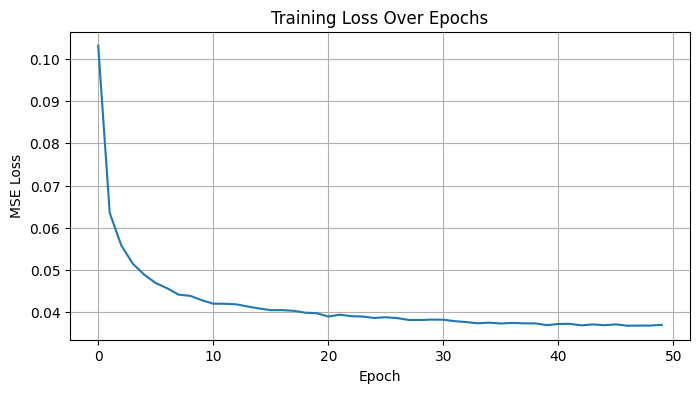

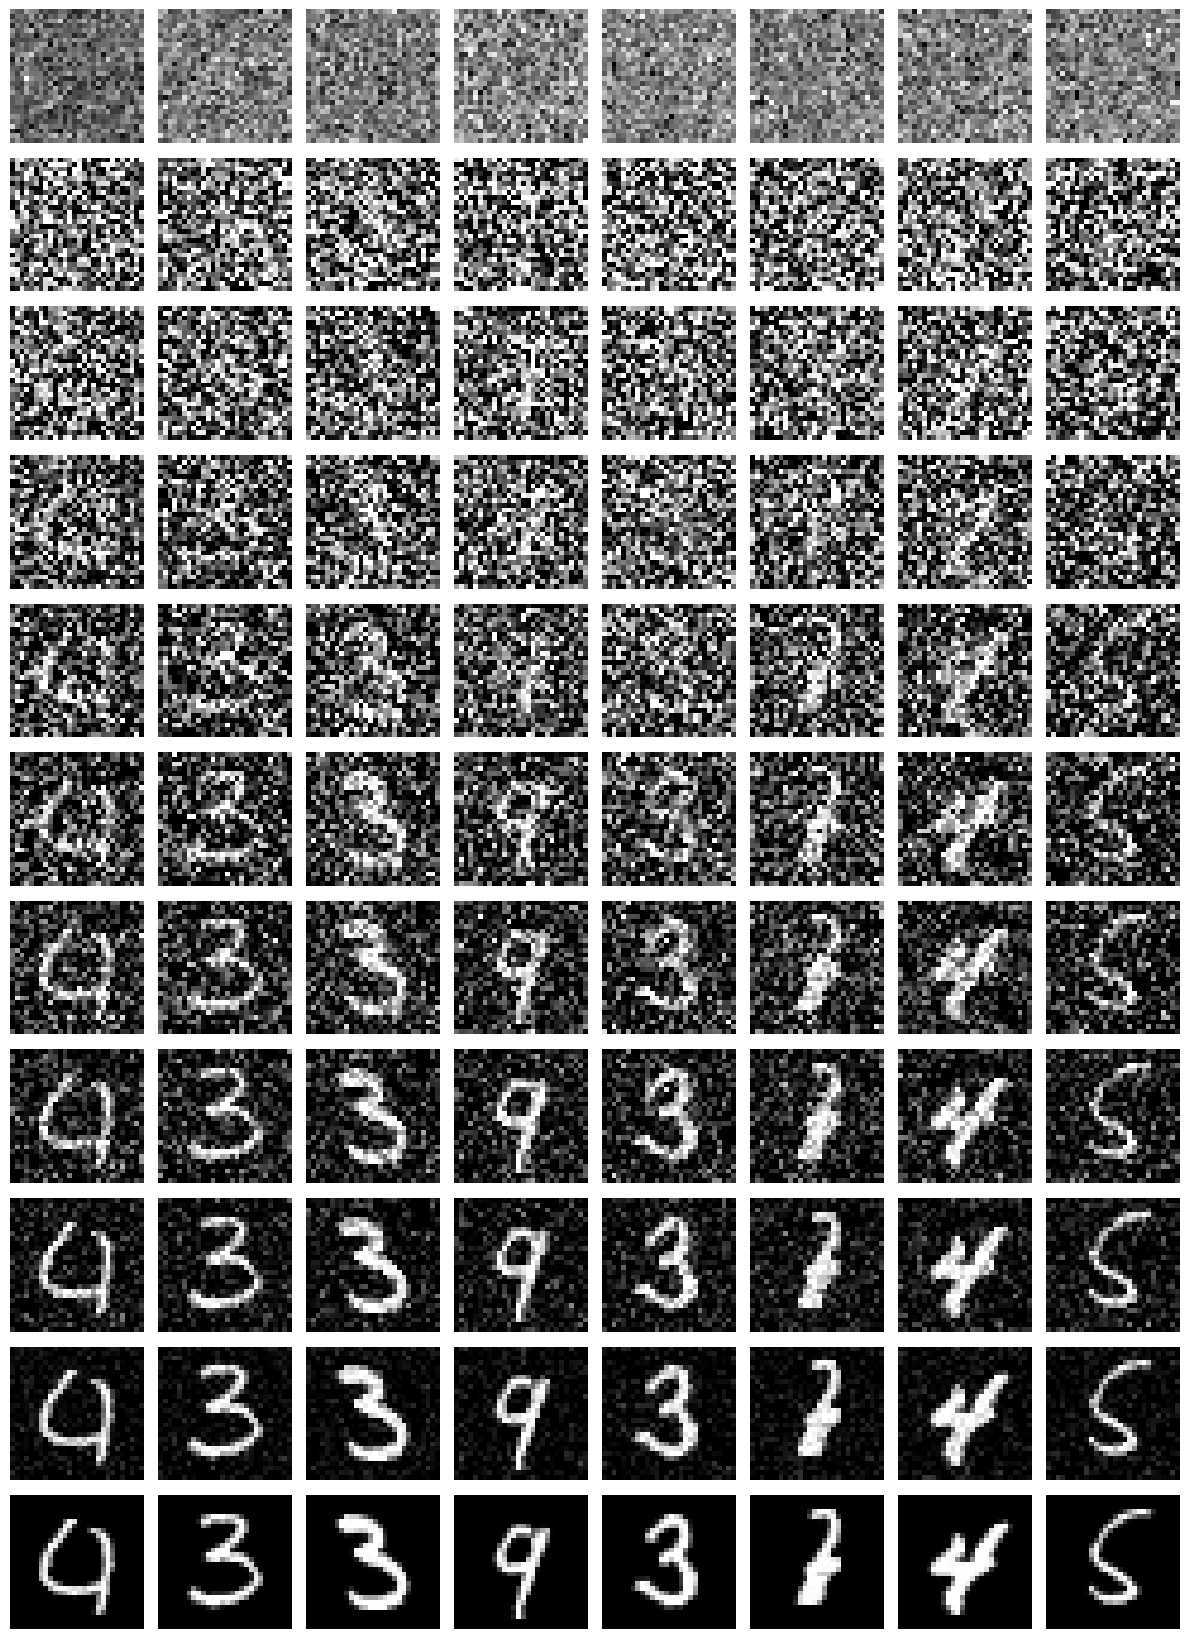

Average L2: 0.1367
Average PSNR: 8.80 dB
Average SSIM: 0.1998


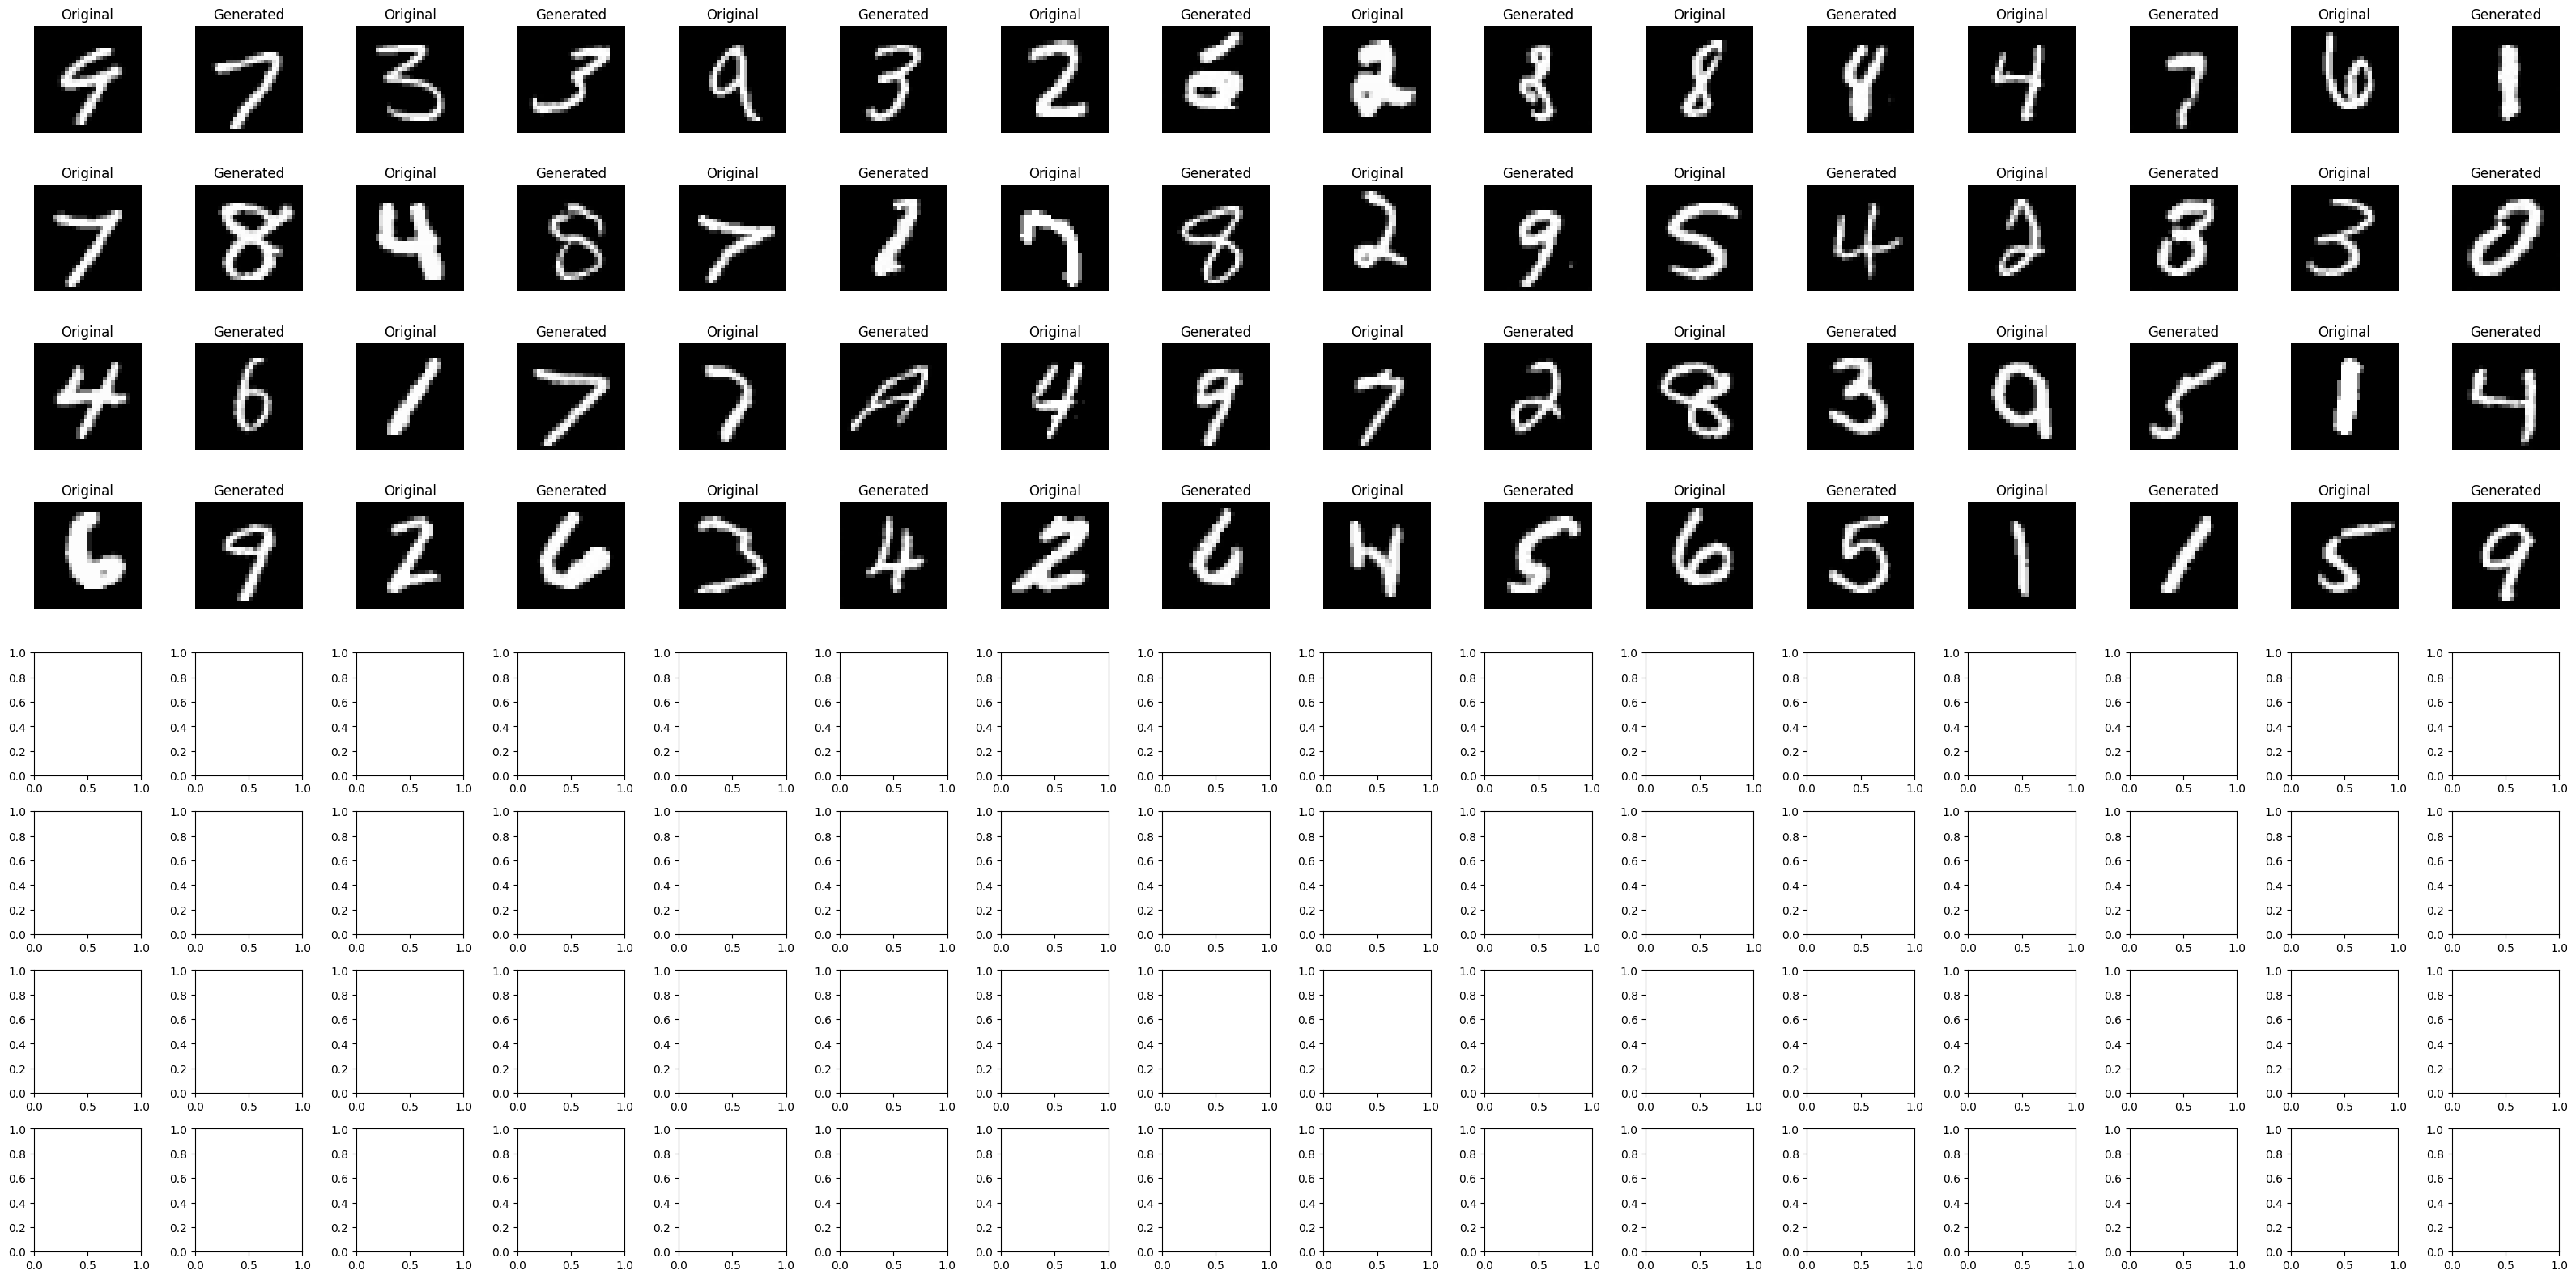

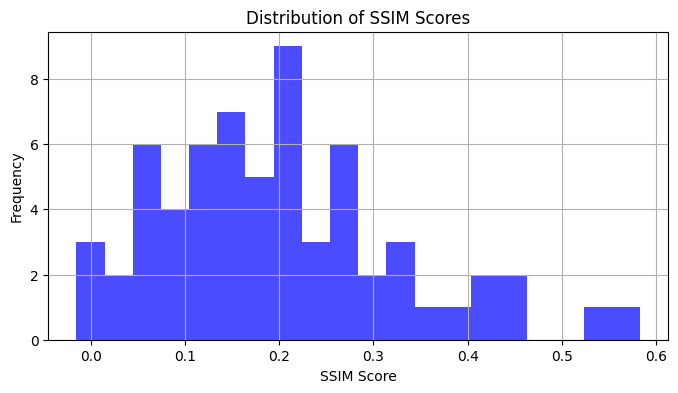

In [ ]:
# ---------------- Main ----------------
if __name__ == "__main__":
    model = UNet(in_channels=1, model_channels=128, time_embed_dim=256).to(device)
    model_path = "improved_ddpm_mnist.pth"

    if not os.path.exists(model_path):
        print("Training model...")
        train_model(model, train_dataloader, epochs=50)
        torch.save(model.state_dict(), model_path)
    else:
        print("Loading pre-trained model...")
        model.load_state_dict(torch.load(model_path, map_location=device))

    final_images, steps_images = generate_with_steps(model, n=8, show_steps=True, step_interval=100)
    visualize_steps(steps_images)
    evaluate_model(model, test_dataset, n=64)